In [112]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import logging

class HMXDataset(Dataset):
    """
    PyTorch Dataset for loading HMX data with configurable padding, spatial dimension reduction,
    sliding window sample generation, and channel-wise normalization.
    """

    def __init__(self, data_dir, future_steps=1, selected_channels=None, 
                 target_size=(512, 1024), dim_reduce=4):
        """
        Args:
            data_dir (str): Path to the directory with the .npy files.
            future_steps (int): Number of timesteps in the future the model will predict.
            selected_channels (list or None): List of channel indices to include. 
                                              If None, include all channels.
            target_size (tuple): Desired spatial dimensions (Height, Width) after padding.
            dim_reduce (int): Factor by which to reduce spatial dimensions.
        """
        self.data_dir = data_dir
        self.files = sorted([
            os.path.join(data_dir, f) 
            for f in os.listdir(data_dir) 
            if f.endswith('.npy')
        ])
        self.future_steps = future_steps
        self.selected_channels = selected_channels
        self.target_size = target_size
        self.dim_reduce = dim_reduce

        # Define channel names for reference
        self.channel_names = ['Temperature', 'Pressure', 'Microstructure', 'Velocity_u', 'Velocity_v']

        # If selected_channels is None, include all channels
        if self.selected_channels is None:
            self.selected_channels = list(range(len(self.channel_names)))
        else:
            # Validate selected_channels
            for ch in self.selected_channels:
                if ch < 0 or ch >= len(self.channel_names):
                    raise ValueError(f"Invalid channel index {ch}. Available channels: 0 to {len(self.channel_names)-1}")

        # Initialize lists to store min and max for each selected channel
        self.channel_min = [np.inf] * len(self.selected_channels)
        
        self.channel_max = [-np.inf] * len(self.selected_channels)

        # List to hold (file_idx, start_t) tuples for each sample
        self.samples = []

        logging.info(f"HMXDataset initialized with {len(self.files)} files.")
        logging.info(f"Selected channels: {[self.channel_names[ch] for ch in self.selected_channels]}")
        logging.info(f"Target size for padding: {self.target_size}")
        logging.info(f"Spatial dimension reduction factor: {self.dim_reduce}")
        logging.info("Calculating channel-wise min and max values for normalization and generating samples...")
        whole_t = 0
        # Precompute channel-wise min and max and generate samples using sliding window
        for file_idx, file in enumerate(self.files):
            data = np.load(file)  # Expected Shape: (H, W, C*T)

            # Verify the shape of the loaded data
            if data.ndim != 3 or data.shape[2] % len(self.channel_names) != 0:
                raise ValueError(f"File '{file}' has invalid shape {data.shape}. Expected (H, W, C*T), where C={len(self.channel_names)}.")

            # Calculate the number of timesteps
            timesteps = data.shape[2] // len(self.channel_names)
            whole_t = timesteps + 1

            # Reshape to separate timesteps and channels: (H, W, T, C)
            data = data.reshape(data.shape[0], data.shape[1], timesteps, len(self.channel_names))

            # Transpose to PyTorch format: (T, C, H, W)
            data = np.transpose(data, (2, 3, 0, 1))  # (Timesteps, Channels, Height, Width)

            # Select desired channels
            data = data[:, self.selected_channels, :, :]  # Shape: (Timesteps, Selected_Channels, H, W)

            # Update min and max for each channel
            
            #if file == ("/project/vil_baek/data/physics/todo_single_void_data/void_112.npy"):
            #    continue
            for idx, channel_idx in enumerate(self.selected_channels):
                channel_data = data[:, idx, :, :]
                current_min = channel_data.min()
                current_max = channel_data.max()
                if current_min < self.channel_min[idx]:
                    self.channel_min[idx] = current_min
                if current_max > self.channel_max[idx]:
                    self.channel_max[idx] = current_max
                    
            

            # Determine the number of valid samples in this file using sliding window
            max_start_t = timesteps - self.future_steps - 1  # -1 because t starts at 0
            for start_t in range(0, max_start_t + 1):
                self.samples.append((file_idx, start_t))

        logging.info("Final channel-wise min and max values after initialization:")
        for idx, ch in enumerate(self.selected_channels):
            logging.info(f"{self.channel_names[ch]}: min={self.channel_min[idx]}, max={self.channel_max[idx]}")

        logging.info(f"Total samples in dataset: {len(self.samples)}")

        # Precompute normalized t1 (time indicators)
        if len(self.files) > 0:
            # Load first file to get timesteps
            sample_data = np.load(self.files[0])
            timesteps = sample_data.shape[2] // len(self.channel_names)
            self.t1 = torch.tensor(
                [(i + 1) / whole_t for i in range(self.future_steps)],
                dtype=torch.float32
            )  # Shape: (future_steps,)
            self.t0 = torch.tensor(0.0, dtype=torch.float32)  # Scalar
        else:
            raise ValueError("No .npy files found in the specified directory.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        # Retrieve the (file_idx, start_t) tuple for this sample
        file_idx, start_t = self.samples[idx]
        file = self.files[file_idx]
        file_name = os.path.basename(file)

        # Load the numpy array for the simulation instance
        data = np.load(file)  # Expected Shape: (H, W, C*T)

        # Verify the shape of the loaded data
        if data.ndim != 3 or data.shape[2] % len(self.channel_names) != 0:
            raise ValueError(f"File '{file_name}' has invalid shape {data.shape}. Expected (H, W, C*T), where C={len(self.channel_names)}.")

        # Calculate the number of timesteps
        timesteps = data.shape[2] // len(self.channel_names)

        # Reshape to separate timesteps and channels: (H, W, T, C)
        data = data.reshape(data.shape[0], data.shape[1], timesteps, len(self.channel_names))

        # Transpose to PyTorch format: (T, C, H, W)
        data = np.transpose(data, (2, 3, 0, 1))  # (Timesteps, Channels, Height, Width)
       

        # Select desired channels
        data = data[:, self.selected_channels, :, :]  # Shape: (Timesteps, Selected_Channels, H, W)
        
        
        # Test clipping timesteps
        data = data[:15, :, :, :] # have 15 timesteps
        

        # Apply padding
        data = self.pad_data(data)  # Shape: (Timesteps, Selected_Channels, target_H, target_W)

        # Optional: Spatial dimension reduction (e.g., block averaging)
        if self.dim_reduce > 1:
            data = self.reduce_spatial_dim(data, self.dim_reduce)  # Adjust spatial dimensions

        # Convert to PyTorch tensor
        data_tensor = torch.from_numpy(data).float()  # Shape: (Timesteps, Selected_Channels, H, W)

        # Normalize each channel between 0 and 1
        data_tensor = self.normalize_tensor(data_tensor)

        # Debug: Verify normalization
        for channel in range(len(self.selected_channels)):
            channel_data = data_tensor[channel].numpy()
            min_val = channel_data.min()
            max_val = channel_data.max()
            if min_val < 0.0 or max_val > 1.0:
                logging.warning(f"Normalization issue in file '{file_name}', channel {self.channel_names[self.selected_channels[channel]]}: min={min_val}, max={max_val}")

        # Initial condition (ic) is the current timestep
        ic = data_tensor[start_t]  # Shape: (Selected_Channels, H, W)

        # Prepare the target sequence (ground truth)
        target = data_tensor[start_t + 1 : start_t + 1 + self.future_steps]  # Shape: (future_steps, Selected_Channels, H, W)

        return ic, self.t0, self.t1, target  # Return the initial condition, t0, t1, and the future ground truth sequence

    def pad_data(self, data):
        """
        Pads the data to the target size using edge padding.

        Args:
            data (numpy.ndarray): Array of shape (T, C, H, W).

        Returns:
            numpy.ndarray: Padded array of shape (T, C, target_H, target_W).
        """
        T, C, H, W = data.shape
        target_H, target_W = self.target_size

        pad_height = max(target_H - H, 0)
        pad_width = max(target_W - W, 0)

        if pad_height > 0 or pad_width > 0:
            pad = (
                (0, 0),  # Timesteps
                (0, 0),  # Channels
                (0, pad_height),  # Height
                (0, pad_width)  # Width
            )
            data = np.pad(data, pad_width=pad, mode='edge')
            logging.debug(f"Padded data from ({H}, {W}) to ({target_H}, {target_W})")
        else:
            logging.debug(f"No padding needed for data with shape ({H}, {W})")

        return data

    def reduce_spatial_dim(self, data, factor):
        """
        Reduces the spatial dimensions by the given factor using block averaging.

        Args:
            data (numpy.ndarray): Array of shape (T, C, H, W).
            factor (int): Factor by which to reduce spatial dimensions.

        Returns:
            numpy.ndarray: Array with reduced spatial dimensions.
        """
        T, C, H, W = data.shape
        new_H = H // factor
        new_W = W // factor

        if new_H == 0 or new_W == 0:
            raise ValueError(f"Reduction factor {factor} is too large for the given dimensions ({H}, {W}).")

        # Truncate the array to make it divisible by the factor
        data = data[:, :, :new_H * factor, :new_W * factor]

        # Reshape and compute the mean
        data = data.reshape(T, C, new_H, factor, new_W, factor).mean(axis=(3, 5))

        logging.debug(f"Reduced spatial dimensions by a factor of {factor}: ({H}, {W}) -> ({new_H}, {new_W})")

        return data

    def normalize_tensor(self, tensor):
        """
        Normalizes each channel of the tensor between 0 and 1 based on precomputed min and max.

        Args:
            tensor (torch.Tensor): The tensor to normalize with shape (C, H, W).

        Returns:
            torch.Tensor: The normalized tensor.
        """
        for idx in range(len(self.selected_channels)):
            min_val = self.channel_min[idx]
            max_val = self.channel_max[idx]
            if max_val - min_val == 0:
                raise ValueError(f"Max and min values for channel {idx} are the same. Cannot normalize.")
            #tensor[idx] = (tensor[idx] - min_val) / (max_val - min_val)
            tensor[:, idx, :, :] = (tensor[:, idx, :, :] - min_val) / (max_val - min_val)
            
        return tensor

def custom_collate_fn(batch):
    """
    Custom collate function to rearrange the target tensor.

    Args:
        batch: A list of tuples (ic, t0, t1, target)

    Returns:
        Batched tensors and fixed time indicators:
            - ic: (batch_size, C, H, W)
            - t0: 0.0 (scalar tensor)
            - t1: (future_steps,) tensor
            - target: (future_steps, batch_size, C, H, W)
    """
    ic, t0, t1, target = zip(*batch)

    # Stack the initial conditions into a tensor
    ic = torch.stack(ic, dim=0)  # Shape: (batch_size, C, H, W)

    # Since t0 is always 0.0, return a single scalar tensor
    t0 = torch.tensor(0.0, dtype=torch.float32)  # Scalar tensor

    # Since t1 is consistent across all samples, take the first one
    t1 = t1[0]  # Shape: (future_steps,)

    # Stack targets into a tensor and permute to match desired shape
    target = torch.stack(target, dim=0).permute(1, 0, 2, 3, 4)  # Shape: (future_steps, batch_size, C, H, W)

    return ic, t0, t1, target

# Example usage
if __name__ == "__main__":
    # Configure logging
    logging.basicConfig(level=logging.INFO)

    # Path to your data directory
    data_dir = '/project/vil_baek/data/physics/todo_single_void_data/'  # Replace with your actual path

    # Define parameters
    future_steps = 2  # Number of future steps to predict
    selected_channels = [0, 1, 2, 3, 4]  # Selecting all channels: T, P, Microstructure, Velocity_u, Velocity_v
    target_size = (512, 1024)
    dim_reduce = 4
    batch_size = 8

    # Initialize the dataset
    hmx_dataset = HMXDataset(
        data_dir=data_dir,
        future_steps=future_steps,
        selected_channels=selected_channels,
        target_size=target_size,
        dim_reduce=dim_reduce
    )

    # Create a DataLoader with the custom collate function
    data_loader = DataLoader(
        hmx_dataset,
        batch_size=batch_size,
        shuffle=False,                   # Set to True if you want to shuffle the data
        num_workers=4,                   # Adjust based on your CPU cores
        pin_memory=True,                 # If using a GPU
        collate_fn=custom_collate_fn     # Use the custom collate function
    )

    # Example to inspect a batch
    for batch in data_loader:
        ic, t0, t1, target = batch
        print("ic shape:", ic.shape)          # (batch_size, C, H, W)
        print("t0:", t0)                      # 0.0
        print("t1 shape:", t1.shape)          # (future_steps,)
        print("target shape:", target.shape)  # (future_steps, batch_size, C, H, W)
        break  # Remove this to iterate through the entire dataset


INFO:root:HMXDataset initialized with 134 files.
INFO:root:Selected channels: ['Temperature', 'Pressure', 'Microstructure', 'Velocity_u', 'Velocity_v']
INFO:root:Target size for padding: (512, 1024)
INFO:root:Spatial dimension reduction factor: 4
INFO:root:Calculating channel-wise min and max values for normalization and generating samples...
INFO:root:Final channel-wise min and max values after initialization:
INFO:root:Temperature: min=300.0, max=5000.0
INFO:root:Pressure: min=-1191545984.0, max=52070417694720.0
INFO:root:Microstructure: min=0.0, max=1.0
INFO:root:Velocity_u: min=-146868.90625, max=9278.1416015625
INFO:root:Velocity_v: min=-64371.44140625, max=63852.140625
INFO:root:Total samples in dataset: 2863


ic shape: torch.Size([8, 5, 128, 256])
t0: tensor(0.)
t1 shape: torch.Size([2])
target shape: torch.Size([2, 8, 5, 128, 256])


In [113]:
# Example usage of DataLoader with the PARCv2 model
for ic, t0, t1, data_tensor in data_loader:
    # Print the shape of the tensors
    print(f"Initial condition (ic) shape: {ic.shape}")
    print(f"t0 shape: {t0.shape}")
    print(f"t1 shape: {t1.shape}")
    print(f"Full data sequence shape: {data_tensor.shape}")
    
    # Break after one batch to avoid printing too much
    break


Initial condition (ic) shape: torch.Size([8, 5, 128, 256])
t0 shape: torch.Size([])
t1 shape: torch.Size([2])
Full data sequence shape: torch.Size([2, 8, 5, 128, 256])


In [114]:
max_values, max_indices = torch.max(ic, dim=1)
min_values, min_indices = torch.min(ic, dim=1)

In [115]:
print(torch.max(ic[0, 2, :, :]))

tensor(1.)


In [116]:
max_values, _ = torch.max(torch.max(ic, dim=1)[0], dim=1)
min_values, _ = torch.min(torch.min(ic, dim=1)[0], dim=1)

print("Maximum values for each channel:", max_values)
print("Minimum values for each channel:", min_values)

Maximum values for each channel: tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])
Minimum values for each channel: tensor([[3.0453e-05, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [2.0242e-04, 2.0242e-04, 2.0241e-04,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.6682e-04, 1.6691e-04, 1.6793e-04,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [1.5328e-04, 1.5354e-04, 1.5386e-04,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.5731e-04, 1.5770e-04, 1.5861e-04,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.7624e-04, 1.7631e-04, 1.7667e-04,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


In [117]:

print(t1)
print(1/22, 2/22, 3/22)

tensor([0.0455, 0.0909])
0.045454545454545456 0.09090909090909091 0.13636363636363635


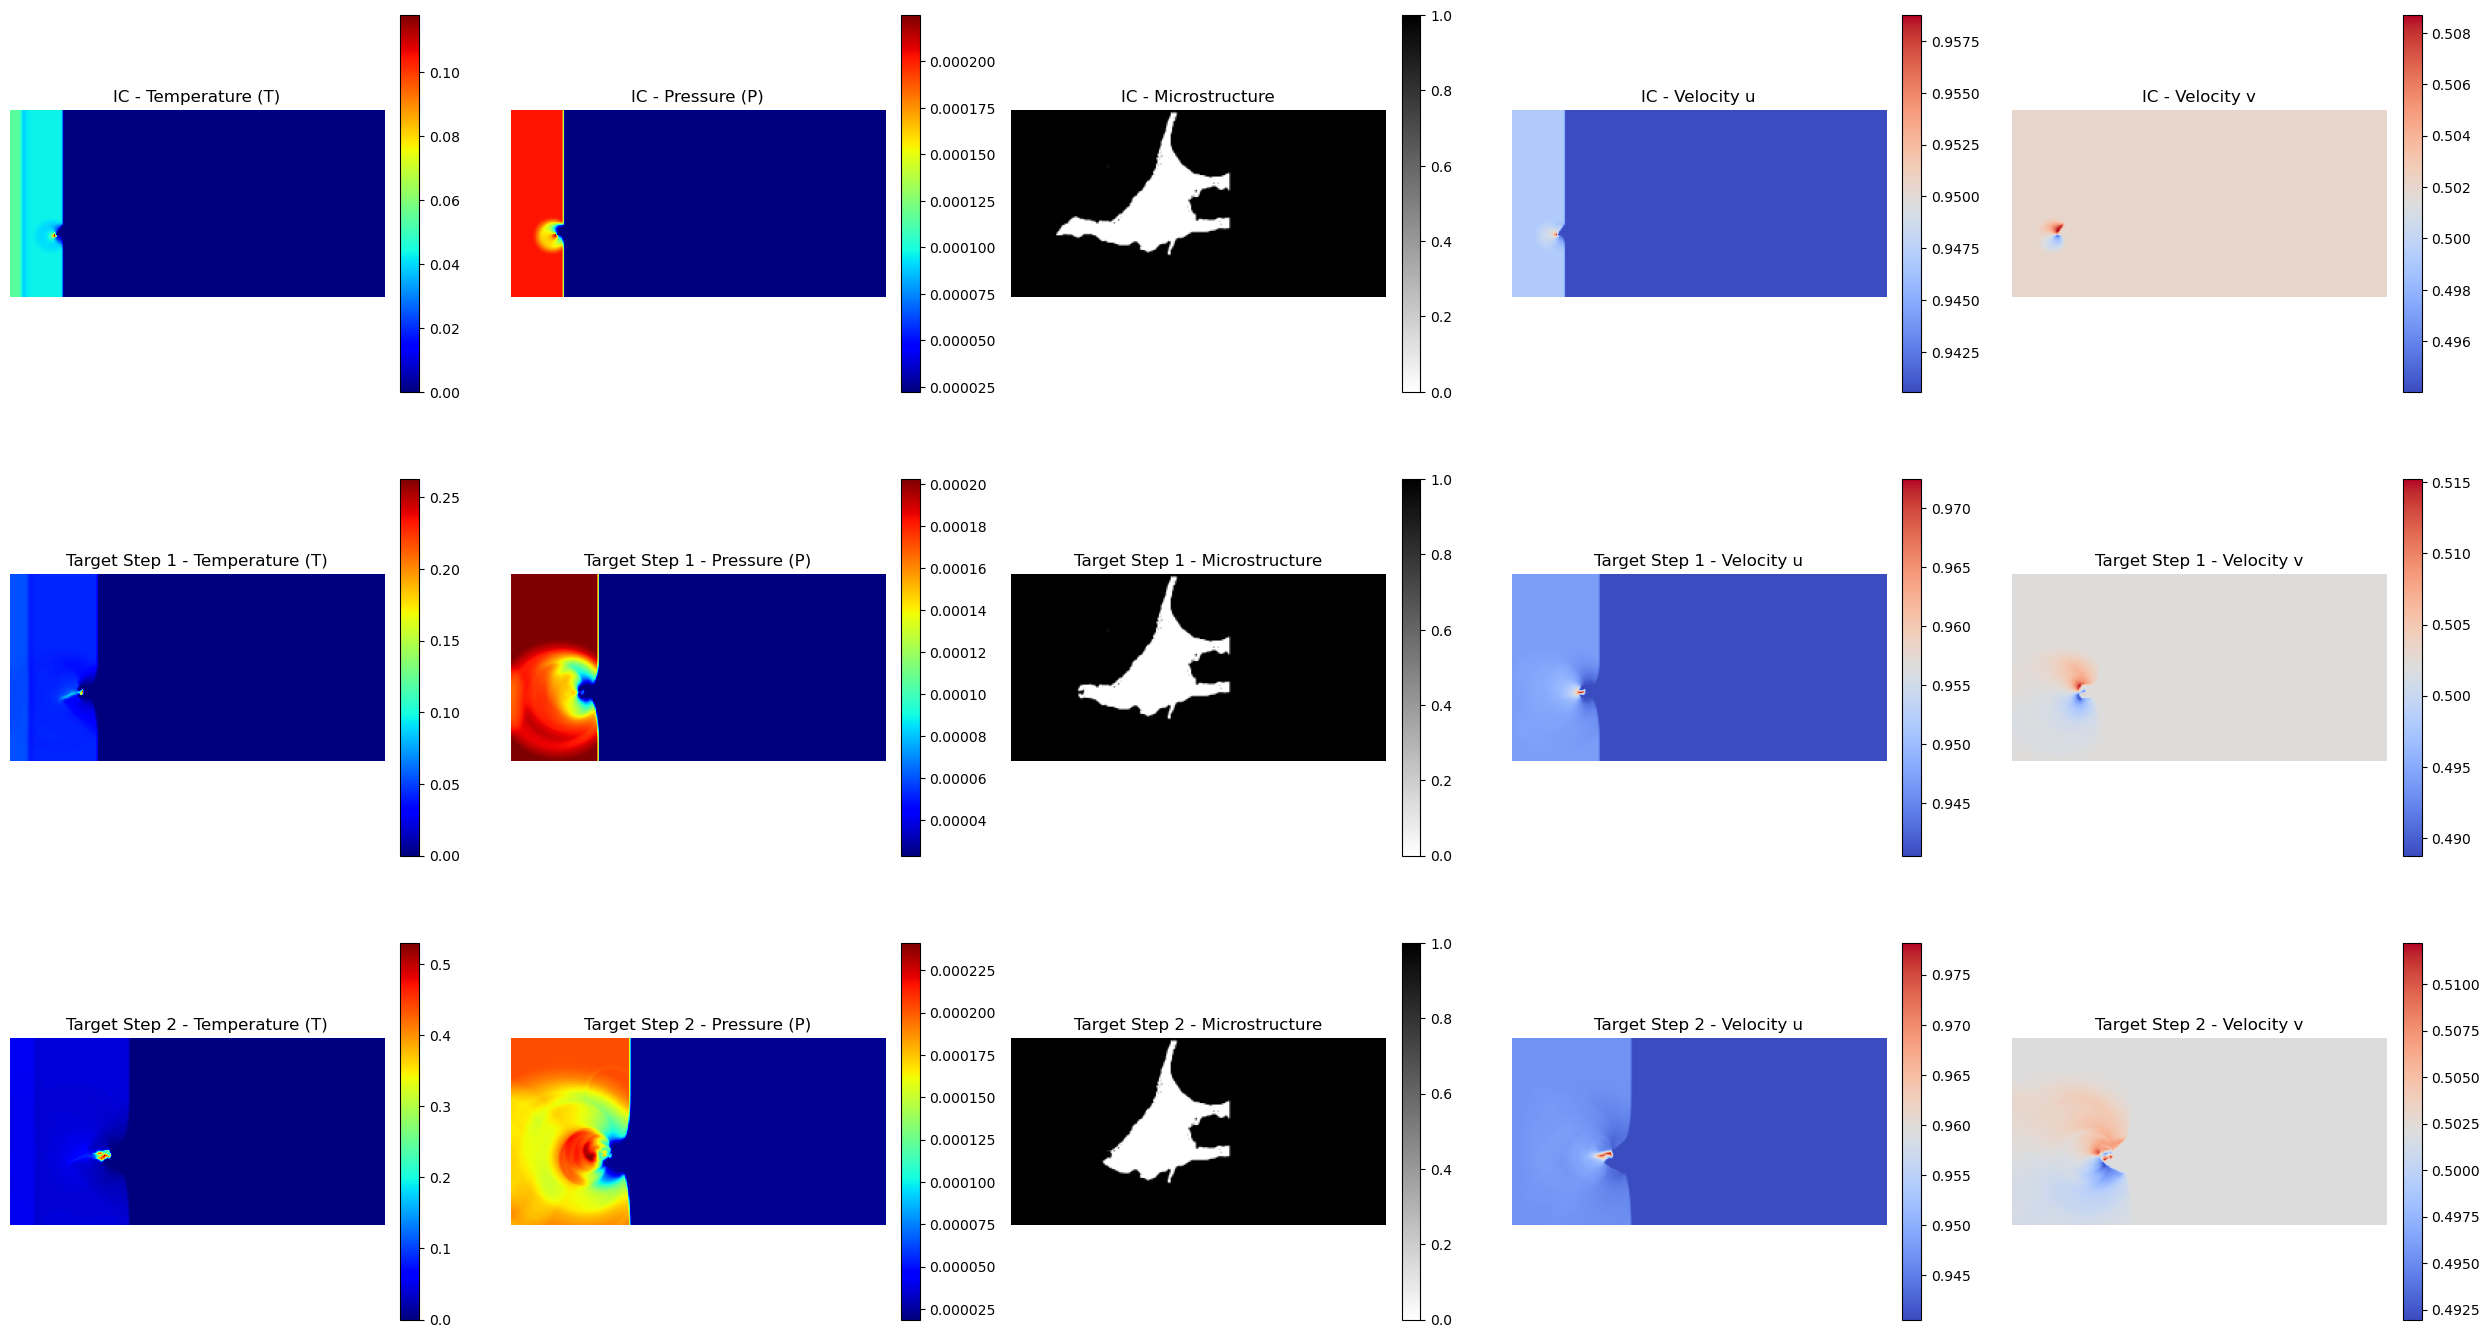

In [118]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Assuming the HMXDataset and DataLoader have been defined as per previous steps

def visualize_hmx_sample(data_loader, dataset, sample_index=0):
    """
    Visualizes the input condition and ground truth sequence for a given sample in the HMX DataLoader.
    
    Args:
        data_loader (DataLoader): The DataLoader instance.
        dataset (HMXDataset): The dataset instance.
        sample_index (int): Index of the sample within the batch to visualize (default is 0).
    """
    # Get one batch from the DataLoader
    batch = next(iter(data_loader))
    ic_batch, t0, t1, target_batch = batch

    # Select the sample_index from the batch
    ic = ic_batch[sample_index]             # Shape: (5, height, width)
    target = target_batch[:, sample_index]   # Shape: (future_steps, 5, height, width)

    # Extract channels
    # Channels: 0 - Temperature (T), 1 - Pressure (P), 2 - Microstructure,
    #          3 - Velocity_u, 4 - Velocity_v
    T_ic = ic[0].numpy()
    P_ic = ic[1].numpy()
    Micro_ic = ic[2].numpy()
    u_ic = ic[3].numpy()
    v_ic = ic[4].numpy()

    # Prepare for visualization
    future_steps = target.shape[0]

    # Define channel titles and corresponding data
    channel_titles = ['Temperature (T)', 'Pressure (P)', 'Microstructure', 'Velocity u', 'Velocity v']
    channel_data_ic = [T_ic, P_ic, Micro_ic, u_ic, v_ic]
    channel_cmaps = ['jet', 'jet', 'binary', 'coolwarm', 'coolwarm']  # Adjust color maps as needed

    # Create subplots
    # We'll create a figure with (future_steps + 1) rows and 5 columns:
    # 1 row for the input condition and 'future_steps' rows for the targets
    fig, axes = plt.subplots(future_steps + 1, 5, figsize=(25, 5 * (future_steps + 1)))

    # Visualization for Input Condition (ic)
    for col in range(5):
        im = axes[0, col].imshow(channel_data_ic[col], cmap=channel_cmaps[col])
        axes[0, col].set_title(f'IC - {channel_titles[col]}')
        axes[0, col].axis('off')
        plt.colorbar(im, ax=axes[0, col], fraction=0.046, pad=0.04)

    # If Microstructure is binary, ensure the color map reflects that
    # Otherwise, adjust as needed based on the nature of the data

    # Visualization for Each Target Timestep
    for step in range(future_steps):
        # Extract target channels
        target_T = target[step, 0].numpy()
        target_P = target[step, 1].numpy()
        target_Micro = target[step, 2].numpy()
        target_u = target[step, 3].numpy()
        target_v = target[step, 4].numpy()

        target_channels = [target_T, target_P, target_Micro, target_u, target_v]

        for col in range(5):
            im = axes[step + 1, col].imshow(target_channels[col], cmap=channel_cmaps[col])
            axes[step + 1, col].set_title(f'Target Step {step + 1} - {channel_titles[col]}')
            axes[step + 1, col].axis('off')
            plt.colorbar(im, ax=axes[step + 1, col], fraction=0.046, pad=0.04)

    # Optional: Add a central title or additional annotations
    # For example, you might want to indicate the timestep or other metadata

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to accommodate suptitle

    # If you have additional information like Reynolds number or other scalar values,
    # you can add them as a suptitle or annotations. For HMXDataset, adjust accordingly.
    # Example:
    # fig.suptitle(f'Visualization of Sample Index {sample_index}', fontsize=16, y=0.98, ha='center')

    plt.show()


visualize_hmx_sample(data_loader, hmx_dataset, sample_index=1)
